# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
import os

In [3]:
path = os.path.join('Tennis_Linux', 'Tennis.x86')

In [4]:
env = UnityEnvironment(file_name=path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [6]:
# # reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents 
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


In [8]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
from DeepRL.deep_rl.network import *
from DeepRL.deep_rl.component import *
from DeepRL.deep_rl.agent.BaseAgent import *
import torchvision


In [7]:
num_agents = 1

In [8]:

class DDPGAgent:
    def __init__(self):
        self.max_steps = int(1e6)
        self.eval_interval = int(1e4)
        self.eval_episodes = 20
        
        state_dim = 24
        action_dim = 2
        self.action_dim = action_dim

        self.network_fn = lambda: DeterministicActorCriticNet(
            state_dim, action_dim,
            actor_body=FCBody(state_dim, (50, 50, 50, 50, 50, 20), gate=F.relu),
            critic_body=FCBody(2*state_dim + action_dim, (100, 50, 50, 50, 50, 50, 20), gate=F.relu),
            actor_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3),
            critic_opt_fn=lambda params: torch.optim.Adam(params, lr=1e-3))

        self.replay_fn = lambda: UniformReplay(memory_size=int(1e6), batch_size=128)
        self.discount = 0.99
        self.random_process_fn = lambda: OrnsteinUhlenbeckProcess(
            size=(action_dim,), std=LinearSchedule(0.1))
        
        self.warm_up = int(1e4)
        
        self.target_network_mix = 5e-3
    
        self.network = self.network_fn()
        self.target_network = self.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        
        self.replay = self.replay_fn()
        
        self.random_process = self.random_process_fn()
        self.random_process.reset_states()
        
        self.total_steps = 0
        self.state = None
        
        self.state_normalizer = lambda x: x
        
        self.device = "cpu" # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.t_step = 0
        
        self.UPDATE_EVERY = 10
        
        self.models = {'network_actor': self.network.actor_body,
                       'network_critic': self.network.critic_body,
                       'target_actor': self.target_network.actor_body,
                       'target_critic': self.target_network.critic_body,
                       'fc_action': self.network.fc_action,
                       'fc_critic': self.network.fc_critic,
                       'target_fc_action': self.target_network.fc_action,
                       'target_fc_action': self.target_network.fc_action,
                       'network_phi': self.network.phi_body,
                       'target_network_phi': self.target_network.phi_body}

    def soft_update(self, target, src):
        for target_param, param in zip(target.parameters(), src.parameters()):
            target_param.detach_()
            target_param.copy_(target_param * (1.0 - self.target_network_mix) +
                               param * self.target_network_mix)
            
    def save(self, model_nm):
        path = os.sep.join(['.', 'model_weights', model_nm])
        if not os.path.exists(path):
            os.makedirs(path)
            
        for nm, model in self.models.items():
            weights = model.state_dict()
            torch.save(weights, os.sep.join([path, nm]))

    def load(self, model_nm):
        path = os.sep.join(['.', 'model_weights', model_nm])
            
        for nm, model in self.models.items():
            state_dict = torch.load(os.sep.join([path, nm]))
            model.load_state_dict(state_dict)
            
    def act(self, state):
        state = torch.from_numpy(state).float().to(self.device)
        
        if self.total_steps < self.warm_up:
            action = np.random.rand(self.action_dim*num_agents).reshape(-1, self.action_dim)
        else:
            action = self.network(state)
            action = to_np(action)
            action += self.random_process.sample()
            
        #Not needed, we will use tanh activation
        #action = np.clip(action, -1, 1)
        
        self.total_steps += 1
        
        return action
        
    def eval_step(self, state):
        state = self.state_normalizer(state)
        action = self.network(state)
        return to_np(action)

    def step(self, state, colleague_state, action, reward, next_state, next_colleague_state, done):

        self.replay.feed(dict(
            state=state,
            colleague_state=colleague_state,
            action=action,
            reward=reward,
            next_state=next_state,
            next_colleague_state=next_colleague_state,
            mask=1-np.asarray(done, dtype=np.int32),
        ))

#         if done:
#             self.random_process.reset_states()

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        
        if (self.t_step == 0) and (self.replay.size() >= self.warm_up):
            self.learn()
        
    def learn(self):
        transitions = self.replay.sample()
        states = tensor(transitions.state)
        colleague_states = tensor(transitions.colleague_state)
        actions = tensor(transitions.action)
        rewards = tensor(transitions.reward).unsqueeze(-1)
        next_states = tensor(transitions.next_state)
        next_colleague_states = tensor(transitions.next_colleague_state)
        mask = tensor(transitions.mask).unsqueeze(-1)

        phi_next = self.target_network.feature(next_states)
        phi_next_colleague = self.target_network.feature(next_colleague_states)
        
        a_next = self.target_network.actor(phi_next)
        q_next = self.target_network.critic(phi_next, phi_next_colleague, a_next)
        q_next = self.discount * mask * q_next
        q_next.add_(rewards)
        q_next = q_next.detach()
        phi = self.network.feature(states)
        phi_colleague = self.network.feature(colleague_states)
        q = self.network.critic(phi, phi_colleague, actions)
        critic_loss = (q - q_next).pow(2).mul(0.5).sum(-1).mean()

        self.network.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.network.critic_params, 1)
        self.network.critic_opt.step()
        
        phi = self.network.feature(states)
        phi_colleague = self.network.feature(colleague_states)
        action = self.network.actor(phi)
        policy_loss = -self.network.critic(phi.detach(), phi_colleague.detach(), action).mean()

        self.network.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.network.actor_params, 1)
        self.network.actor_opt.step()

        self.soft_update(self.target_network, self.network)

In [9]:
n_episodes=10000000
max_t=10000

#### State standardization
I accumulated samples in the replay buffer and then just got empirical mean and max. absolute values around that mean.

In [10]:
mean_state = np.array([-4.80006529e+00,  1.36604393e-02,  5.99677352e+00,  8.16729930e-01,
       -6.04321677e-02,  2.99387520e+00,  5.99677352e+00,  8.16729930e-01,
       -5.07671490e+00,  6.29919302e-03,  6.35296714e+00,  5.96779433e-01,
       -6.25882435e-02,  2.88864339e+00,  6.35296714e+00,  5.96779433e-01,
       -5.37267477e+00, -3.38142435e-02,  6.99621777e+00,  3.08744504e-01,
       -8.68654266e-02,  2.74919914e+00,  6.99621777e+00,  3.08744504e-01])

maxi_state = np.array([ 6.66741537,  1.86601985, 35.99677352, 11.28007832, 11.70666   ,
        4.74047845, 35.99677352, 11.28007832,  6.39904747,  1.85865861,
       36.35296714, 11.06012782, 11.75664762,  5.11374653, 36.35296714,
       11.06012782,  6.10549468,  1.81854517, 36.99621777, 10.77209289,
       11.89764881,  5.63183807, 36.99621777, 10.77209289])

In [15]:
from collections import deque
scores_l = []  # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
best_score = 0
agent = DDPGAgent()

for i_episode in range(1, n_episodes + 1):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment   
    states = (env_info.vector_observations - mean_state) / maxi_state            # get the current state (for each agent)
    state_left = states[:1]
    state_right = states[1:]
    scores_left = 0
    scores_right = 0

    agent.random_process.reset_states() # should this really be restarted every episode?

    while True:
        #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        action_left = agent.act(state_left)                # all actions between -1 and 1
        action_right = agent.act(state_right)
        actions = np.vstack([action_left, action_right])
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = (env_info.vector_observations - mean_state) / maxi_state      # get next state (for each agent)
        next_state_left = next_states[:1]
        next_state_right = next_states[1:] #* sign
        rewards = env_info.rewards                         # get reward (for each agent)
        rewards_left = rewards[:1]
        rewards_right = rewards[1:]
        dones = env_info.local_done                        # see if episode finished
        dones_left = dones[:1]
        dones_right = dones[1:]
        scores_left += rewards_left[0]
        scores_right += rewards_right[0]                     # update the score (for each agent)
        agent.step(state_left, state_right, action_left, rewards_left+rewards_right, next_state_left, next_state_right, dones_left)
        agent.step(state_right, state_left, action_right, rewards_right+rewards_left, next_state_right, next_state_left, dones_right)
        states = next_states                               # roll over states to next time step
        state_left = states[:1]
        state_right = states[1:]
        if np.any(dones):                                  # exit loop if episode finished
            break

    scores_window.append(max(scores_left, scores_right))  # save most recent score
    scores_l.append(max(scores_left, scores_right))  # save most recent score

    rolling_score = np.mean(scores_window)
    if (rolling_score > 0.5) & (rolling_score > best_score):
        best_score = rolling_score
        agent.save('better_model')
        
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode,
                                                   rolling_score),
                                                  end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window) >= 2:
        print(
        '\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
          i_episode - 100, np.mean(scores_window)))
        agent.save('successfull_model')
        break

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.06
Episode 700	Average Score: 0.01
Episode 800	Average Score: 0.03
Episode 900	Average Score: 0.01
Episode 1000	Average Score: 0.01
Episode 1100	Average Score: 0.00
Episode 1200	Average Score: 0.01
Episode 1300	Average Score: 0.00
Episode 1400	Average Score: 0.03
Episode 1500	Average Score: 0.01
Episode 1600	Average Score: 0.01
Episode 1700	Average Score: 0.08
Episode 1800	Average Score: 0.11
Episode 1900	Average Score: 0.10
Episode 2000	Average Score: 0.10
Episode 2100	Average Score: 0.10
Episode 2200	Average Score: 0.15
Episode 2300	Average Score: 0.15
Episode 2400	Average Score: 0.17
Episode 2500	Average Score: 0.17
Episode 2600	Average Score: 0.23
Episode 2700	Average Score: 0.26
Episode 2800	Average Score: 0.14
Episode 2900	Average Score: 0.22
Episode 3000	Average Score: 0.18
Episode 3100	Averag

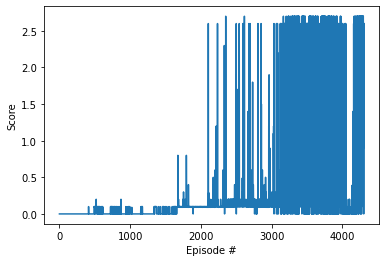

In [19]:
# plot the scores
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_l)), scores_l)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [51]:
env.close()